# Udacity ML Capstone: Predicting Device Failures
### by Michael Lin



Our challenge is to build a machine learning model to predict the probability of a device failure. Success criteria is to correctly identify the true failure cases, while at the same time, minimize false positives and false negatives.

## First Look at Data

We'll start by looking at the dataset, getting a feel for the challenge, before formulating our game plan. 

Initial analysis of the data reveals the following: 

- The dataset is telemetry logs of 124,494 records, collected from 1,169 devices. 

- The device failure rate is about 9.07%.  

- The data sources possilby comes from 3 device types.

- The data coverage spans time period of 2015/1/1 to 2015/11/2. 

- The duration of the device in service also varies widely, ranging from 1 day to 304 days.

- In terms of features, we have 9 attributes which are numerical in nature.   



In [1]:
# install dependencies

# !conda install -c numpy pandas matplotlib seaborn scikit-learn -y
# !conda install -c conda-forge imbalanced-learn -y
# !conda install -c conda-forge xgboost -y
# !conda install -c conda-forge lightgbm -y

In [2]:
# load in sample dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

url = 'https://udacity-data-michlin0825.s3-ap-northeast-1.amazonaws.com/device_failure.csv'
df = pd.read_csv(url, header = 0, delimiter = ',', encoding = "ISO-8859-1")
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
# total number of daily logs

df.count()[0]

124494

In [4]:
# daily logs with failure record

len(df[df['failure']==1])

106

In [5]:
# percentage of daily logs with failure

len(df[df['failure']==1]) / df.count()[0] * 100

0.0851446656063746

In [6]:
# total number of device 

len(df.groupby('device'))

1169

In [7]:
# percentage of device with failure

len(df[df['failure']==1]) / len(df.groupby('device')) * 100

9.067579127459368

In [8]:
# device types

df['device'].str[:3].value_counts(normalize = True)

S1F    0.440648
W1F    0.347551
Z1F    0.211801
Name: device, dtype: float64

In [9]:
# dataset timeframe

df['date'].head(1)

0    2015-01-01
Name: date, dtype: object

In [10]:
df['date'].tail(1)

124493    2015-11-02
Name: date, dtype: object

In [11]:
# device service days

print(df.groupby('device')['date'].count().max())
print(df.groupby('device')['date'].count().mean())
print(df.groupby('device')['date'].count().min())

304
106.4961505560308
1


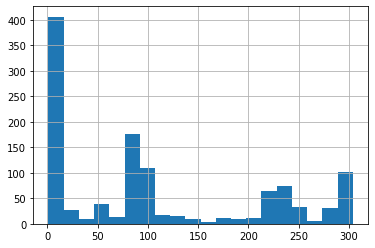

In [12]:
df.groupby('device')['date'].count().hist(bins = 20)

In [13]:
# nature of attributes: continuous vs. categorical

df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [14]:
# check unique values/levels of the attributes

print(df['attribute1'].nunique())
print(df['attribute2'].nunique())
print(df['attribute3'].nunique())
print(df['attribute4'].nunique())
print(df['attribute5'].nunique())
print(df['attribute6'].nunique())
print(df['attribute7'].nunique())
print(df['attribute8'].nunique())
print(df['attribute9'].nunique())

123877
558
47
115
60
44838
28
28
65


In [15]:
# save raw data to file
df.to_csv('device_failure.csv', index = None, header=True) 

## Game plan

We envision the assignment as a classification challenge. 

In designing the solution, we keep the following considerations in mind: 

- The distribution of the label, failure, is highly skewed. We may need case weighting or data resampling to enable our model with sufficient exposure to both failure and non-failure classes . This is required so model can produce robust parameter estimates. 

- Devices do not have equal number of log records. We have to reconstruct a dataset fixing granularity at the device level, with proper labelling of failure or non failure at each device's last point of observation. 

- In term of feature engineering, we can explore patterns along weekday pattern, seasonality, and/or device types. 

- In terms of attributes, we need to align sensor reading of the previous 1 day, previous 2 days, and previous 3 days to eventual failure incidence. 

- As for model selection, we use area under the curve (AUC) to guide our model search, balancing precision vs. recall at the same time. Simple accuracy measurement is not effective in the face of imbalanced dataset. Naive prediction of all devices never fail gets us to 91% accuracy.  

- As for model evalaution, we manually hold out 20% of data for validation. Our model's performance is measured against the hold-out dataset. 

- Depending on the natrue of the underlying relationship between features and label, more complex models may be required to pick up non-linearity and/or feature interactions. We'll gradually consider more complex models as result of the simpler models come in. 


## Analysis Flow

Our analysis will stick to the following steps:  

1. clean data
2. generate features and construct working dataset 
3. split dataset into training and validation
4. resample minority class in training dataset  
5. establish prediction baseline 
6. fit classification models for comparisons
7. fit ensemble models to enhance predictions 
8. tune ensemble hyperparameters for better performance 
9. adjust prediction cut-off point
10. explore other avenues to make continous improvement

## 1. Data Cleaning 

In this phase of data prepration, we achieve the following objectives: 

- We identify a duplicate record in the device log, and decide to drop it. 

- We find attribute8 and attribute9 with perfect correlation, reflecting possibly duplicate entries. We opt to drop attribute9 to avoid perfect collineraity. 

- We do not find missing data points, so there's no need to impute missing values.  

- Features attribute1 to attribute9 do not conform to normal distribution, and varies widely in terms of scale. We have options to either normalize the scale to range between 0 and 1 and avoid potential outlier(s), or standardize the scale constrainting to unit variance of one. The latter will make attributes across the board with the same order of magnitude. Without context of what these attributes mean in practice, it's difficult to interpret outlier. On the other hand, feature variance across attributes do pose challenge to some of the models we plan to fit in the later stage, e.g. KNN, SVM. Hence our plan is to standardize those numerical features in due course. 


In [16]:
# data cleaning

In [17]:
# delete duplicate rows

In [18]:
df.count()

date          124494
device        124494
failure       124494
attribute1    124494
attribute2    124494
attribute3    124494
attribute4    124494
attribute5    124494
attribute6    124494
attribute7    124494
attribute8    124494
attribute9    124494
dtype: int64

In [19]:
df.drop_duplicates().count()

date          124493
device        124493
failure       124493
attribute1    124493
attribute2    124493
attribute3    124493
attribute4    124493
attribute5    124493
attribute6    124493
attribute7    124493
attribute8    124493
attribute9    124493
dtype: int64

In [20]:
df = df.drop_duplicates()
df.count()

date          124493
device        124493
failure       124493
attribute1    124493
attribute2    124493
attribute3    124493
attribute4    124493
attribute5    124493
attribute6    124493
attribute7    124493
attribute8    124493
attribute9    124493
dtype: int64

In [21]:
# check column correlation 

In [22]:
df.corr()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
failure,1.000000,0.001984,0.052902,-0.000948,0.067398,0.002270,-0.000550,0.119055,0.119055,0.001622
attribute1,0.001984,1.000000,-0.004249,0.003702,0.001836,-0.003373,-0.001518,0.000151,0.000151,0.001121
attribute2,0.052902,-0.004249,1.000000,-0.002617,0.146593,-0.013999,-0.026350,0.141367,0.141367,-0.002736
attribute3,-0.000948,0.003702,-0.002617,1.000000,0.097452,-0.006697,0.009027,-0.001884,-0.001884,0.532366
attribute4,0.067398,0.001836,0.146593,0.097452,1.000000,-0.009773,0.024870,0.045631,0.045631,0.036069
attribute5,0.002270,-0.003373,-0.013999,-0.006697,-0.009773,1.000000,-0.017051,-0.009384,-0.009384,0.005949
attribute6,-0.000550,-0.001518,-0.026350,0.009027,0.024870,-0.017051,1.000000,-0.012207,-0.012207,0.021152
attribute7,0.119055,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
attribute8,0.119055,0.000151,0.141367,-0.001884,0.045631,-0.009384,-0.012207,1.000000,1.000000,0.006861
attribute9,0.001622,0.001121,-0.002736,0.532366,0.036069,0.005949,0.021152,0.006861,0.006861,1.000000


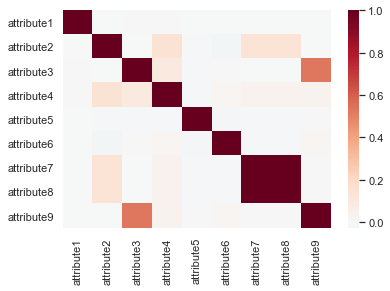

In [23]:
df_att = df[['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 
             'attribute6', 'attribute7', 'attribute8', 'attribute9']]
corr_pearson = df_att.corr() 

import seaborn as sns
sns.set()
sns.heatmap(corr_pearson, center = 0, cmap = 'RdBu_r')

In [24]:
# attribute8 and attribute9 perfectly correlated. dropping attribute9 to avoid perfect collineraity

In [25]:
df = df.drop(['attribute9'], axis=1)

In [26]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0


In [27]:
# check missing data

In [28]:
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
dtype: int64

In [29]:
# check feature distribution and evaluate if normalize/standardize

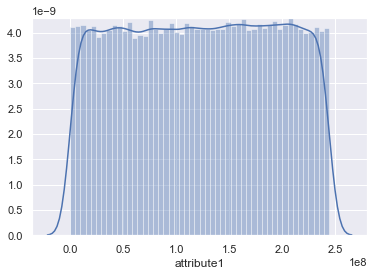

In [30]:
sns.distplot(df['attribute1'])

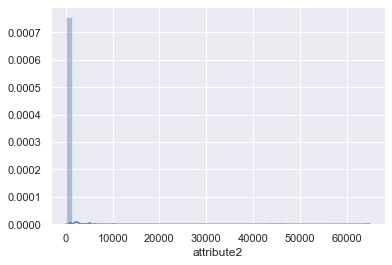

In [31]:
sns.distplot(df['attribute2'])

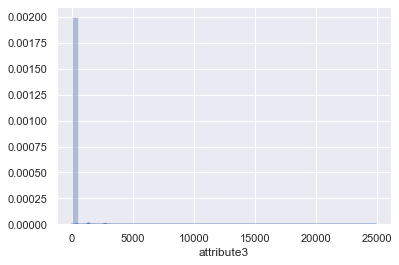

In [32]:
sns.distplot(df['attribute3'])

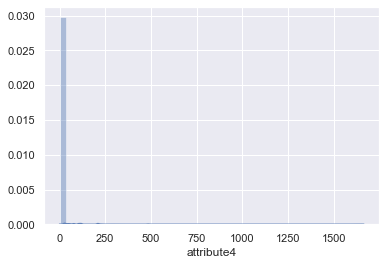

In [33]:
sns.distplot(df['attribute4'])

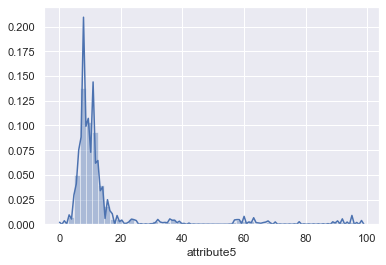

In [34]:
sns.distplot(df['attribute5'])

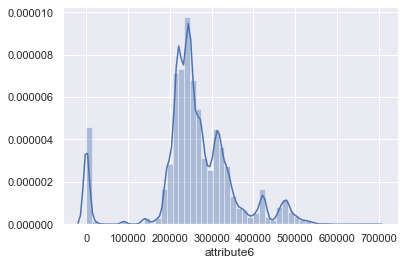

In [35]:
sns.distplot(df['attribute6'])

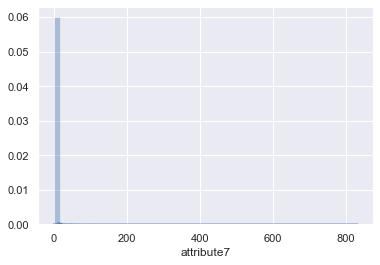

In [36]:
sns.distplot(df['attribute7'])

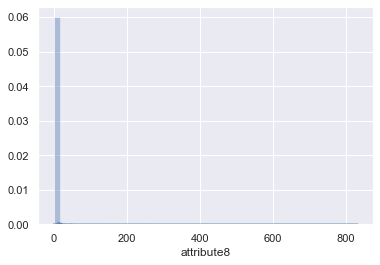

In [37]:
sns.distplot(df['attribute8'])

In [38]:
# we'll standardize in later cross-validation loop to avoid possible 'data leakage'

## 2. Feature Engineering

- We hypothesize that device failure may reflect scheduling pattern. We explicitely model weekday, Monday to Sunday, to simulate the effect.

- We also suspect seasonable effect. We model month, Janaury to December, to gauge the impact. 

- We calculate the days the device is in service before failure. We use this to pick up effect of usage on failure. 

- In terms of device type, namely 'S1F', 'W1F', 'Z1F'. We model it to explore influence of device family on failure. 

- For attributes, we extract sensor readings of the past 1 day, past 2 days, and past 3 days to align with the label for model training. 

In [39]:
# day of week

df1 = df.copy()
df1 = df1.drop(['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8'], axis = 1)

df1['date2'] = pd.to_datetime(df1['date'])
df1['day_of_week'] = df1['date2'].dt.weekday
df1.head()

,date,device,failure,date2,day_of_week
0,2015-01-01,S1F01085,0,2015-01-01,3
1,2015-01-01,S1F0166B,0,2015-01-01,3
2,2015-01-01,S1F01E6Y,0,2015-01-01,3
3,2015-01-01,S1F01JE0,0,2015-01-01,3
4,2015-01-01,S1F01R2B,0,2015-01-01,3


In [40]:
# month of year

df1['month_of_year'] = df1['date2'].dt.month
df1.head()

,date,device,failure,date2,day_of_week,month_of_year
0,2015-01-01,S1F01085,0,2015-01-01,3,1
1,2015-01-01,S1F0166B,0,2015-01-01,3,1
2,2015-01-01,S1F01E6Y,0,2015-01-01,3,1
3,2015-01-01,S1F01JE0,0,2015-01-01,3,1
4,2015-01-01,S1F01R2B,0,2015-01-01,3,1


In [41]:
# service days

service_days_map = (df1.groupby('device')['date'].count() -1).to_dict()
df1['service_days'] = df1['device'].map(service_days_map)

df1.head()

,date,device,failure,date2,day_of_week,month_of_year,service_days
0,2015-01-01,S1F01085,0,2015-01-01,3,1,5
1,2015-01-01,S1F0166B,0,2015-01-01,3,1,5
2,2015-01-01,S1F01E6Y,0,2015-01-01,3,1,47
3,2015-01-01,S1F01JE0,0,2015-01-01,3,1,5
4,2015-01-01,S1F01R2B,0,2015-01-01,3,1,222


In [42]:
# device type

df1['device_type'] = df1['device'].str[:3]

df1.head()

,date,device,failure,date2,day_of_week,month_of_year,service_days,device_type
0,2015-01-01,S1F01085,0,2015-01-01,3,1,5,S1F
1,2015-01-01,S1F0166B,0,2015-01-01,3,1,5,S1F
2,2015-01-01,S1F01E6Y,0,2015-01-01,3,1,47,S1F
3,2015-01-01,S1F01JE0,0,2015-01-01,3,1,5,S1F
4,2015-01-01,S1F01R2B,0,2015-01-01,3,1,222,S1F


In [43]:
# reindex using device and date to faciliate device/time specific feature extraction

In [44]:
df1 = df1.drop(['date2'], axis = 1)
df1.sort_values(by=['device', 'date'])
df1 = df1.set_index(['device', 'date'], drop = True)
df1 = df1.sort_index(axis=0)

In [45]:
df1_cut = df1.groupby(level=0).tail(1).dropna()
df1_cut.head()

,,failure,day_of_week,month_of_year,service_days,device_type
device,date,,,,,
S1F01085,2015-01-06,0,1,1,5,S1F
S1F013BB,2015-05-11,0,0,5,5,S1F
S1F0166B,2015-01-06,0,1,1,5,S1F
S1F01E6Y,2015-02-17,0,1,2,47,S1F
S1F01JE0,2015-01-06,0,1,1,5,S1F


In [46]:
# construct sensor reading from previous day, previous 2 days, and previous 3 days as features

In [47]:
df2 = df.copy()
df2.sort_values(by=['device', 'date'])
df2 = df2.set_index(['device', 'date'], drop = True)
df2 = df2.sort_index(axis=0)

In [48]:
df2.drop(['failure'], axis =1, inplace = True)
df_pre1day = df2.groupby(level=0).shift(periods = 1, fill_value = np.NaN)
df_pre2day = df2.groupby(level=0).shift(periods = 2, fill_value = np.NaN)
df_pre3day = df2.groupby(level=0).shift(periods = 3, fill_value = np.NaN)

In [49]:
df_pre1day = df_pre1day.rename(columns = {'attribute1': 'att1_pre1day', 'attribute2': 'att2_pre1day', 'attribute3': 'att3_pre1day', 'attribute4': 'att4_pre1day', 'attribute5': 'att5_pre1day', 'attribute6': 'att6_pre1day', 'attribute7': 'att7_pre1day', 'attribute8': 'att8_pre1day'})
df_pre1day.head()


att1_pre1day  att2_pre1day  att3_pre1day  att4_pre1day  \
device   date                                                                 
S1F01085 2015-01-01           NaN           NaN           NaN           NaN   
         2015-01-02   215630672.0          56.0           0.0          52.0   
         2015-01-03     1650864.0          56.0           0.0          52.0   
         2015-01-04   124017368.0          56.0           0.0          52.0   
         2015-01-05   128073224.0          56.0           0.0          52.0   

                     att5_pre1day  att6_pre1day  att7_pre1day  att8_pre1day  
device   date                                                                
S1F01085 2015-01-01           NaN           NaN           NaN           NaN  
         2015-01-02           6.0      407438.0           0.0           0.0  
         2015-01-03           6.0      407438.0           0.0           0.0  
         2015-01-04           6.0      407438.0           0.0           0.0  
         2015-01-05           6.0      407439.0           0.0           0.0

In [50]:
df_pre2day = df_pre2day.rename(columns = {'attribute1': 'att1_pre2day', 'attribute2': 'att2_pre2day', 'attribute3': 'att3_pre2day', 'attribute4': 'att4_pre2day', 'attribute5': 'att5_pre2day', 'attribute6': 'att6_pre2day', 'attribute7': 'att7_pre2day', 'attribute8': 'att8_pre2day'})
df_pre2day.head()


att1_pre2day  att2_pre2day  att3_pre2day  att4_pre2day  \
device   date                                                                 
S1F01085 2015-01-01           NaN           NaN           NaN           NaN   
         2015-01-02           NaN           NaN           NaN           NaN   
         2015-01-03   215630672.0          56.0           0.0          52.0   
         2015-01-04     1650864.0          56.0           0.0          52.0   
         2015-01-05   124017368.0          56.0           0.0          52.0   

                     att5_pre2day  att6_pre2day  att7_pre2day  att8_pre2day  
device   date                                                                
S1F01085 2015-01-01           NaN           NaN           NaN           NaN  
         2015-01-02           NaN           NaN           NaN           NaN  
         2015-01-03           6.0      407438.0           0.0           0.0  
         2015-01-04           6.0      407438.0           0.0           0.0  
         2015-01-05           6.0      407438.0           0.0           0.0

In [51]:
df_pre3day = df_pre3day.rename(columns = {'attribute1': 'att1_pre3day', 'attribute2': 'att2_pre3day', 'attribute3': 'att3_pre3day', 'attribute4': 'att4_pre3day', 'attribute5': 'att5_pre3day', 'attribute6': 'att6_pre3day', 'attribute7': 'att7_pre3day', 'attribute8': 'att8_pre3day'})
df_pre3day.head()


att1_pre3day  att2_pre3day  att3_pre3day  att4_pre3day  \
device   date                                                                 
S1F01085 2015-01-01           NaN           NaN           NaN           NaN   
         2015-01-02           NaN           NaN           NaN           NaN   
         2015-01-03           NaN           NaN           NaN           NaN   
         2015-01-04   215630672.0          56.0           0.0          52.0   
         2015-01-05     1650864.0          56.0           0.0          52.0   

                     att5_pre3day  att6_pre3day  att7_pre3day  att8_pre3day  
device   date                                                                
S1F01085 2015-01-01           NaN           NaN           NaN           NaN  
         2015-01-02           NaN           NaN           NaN           NaN  
         2015-01-03           NaN           NaN           NaN           NaN  
         2015-01-04           6.0      407438.0           0.0           0.0  
         2015-01-05           6.0      407438.0           0.0           0.0

In [52]:
# merge sensor reading of all 8 attributes, from previous 1 day to 3 days. 

df2_total_cut = pd.concat([df_pre1day, df_pre2day, df_pre3day], axis = 1).dropna().groupby(level = 0).tail(1).dropna()
df2_total_cut.head()


,,att1_pre1day,att2_pre1day,att3_pre1day,att4_pre1day,att5_pre1day,att6_pre1day,att7_pre1day,att8_pre1day,att1_pre2day,att2_pre2day,...,att7_pre2day,att8_pre2day,att1_pre3day,att2_pre3day,att3_pre3day,att4_pre3day,att5_pre3day,att6_pre3day,att7_pre3day,att8_pre3day
device,date,,,,,,,,,,,,,,,,,,,,,
S1F01085,2015-01-06,97393448.0,56.0,0.0,52.0,6.0,408114.0,0.0,0.0,128073224.0,56.0,...,0.0,0.0,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0
S1F013BB,2015-05-11,85127128.0,0.0,0.0,0.0,5.0,689062.0,0.0,0.0,243346080.0,0.0,...,0.0,0.0,214383720.0,0.0,0.0,0.0,5.0,688964.0,0.0,0.0
S1F0166B,2015-01-06,224339296.0,0.0,3.0,0.0,6.0,403812.0,0.0,0.0,82195688.0,0.0,...,0.0,0.0,77681360.0,0.0,3.0,0.0,6.0,403174.0,0.0,0.0
S1F01E6Y,2015-02-17,182876688.0,0.0,0.0,0.0,12.0,259486.0,0.0,0.0,227370128.0,0.0,...,0.0,0.0,83214688.0,0.0,0.0,0.0,12.0,259468.0,0.0,0.0
S1F01JE0,2015-01-06,158246712.0,0.0,0.0,0.0,6.0,410888.0,0.0,0.0,235473648.0,0.0,...,0.0,0.0,235562856.0,0.0,0.0,0.0,6.0,410186.0,0.0,0.0


In [53]:
# merge all features

df_w = pd.merge(left = df1_cut, left_index = True, right = df2_total_cut, right_index = True, how = 'inner')
df_w.head()


,,failure,day_of_week,month_of_year,service_days,device_type,att1_pre1day,att2_pre1day,att3_pre1day,att4_pre1day,att5_pre1day,...,att7_pre2day,att8_pre2day,att1_pre3day,att2_pre3day,att3_pre3day,att4_pre3day,att5_pre3day,att6_pre3day,att7_pre3day,att8_pre3day
device,date,,,,,,,,,,,,,,,,,,,,,
S1F01085,2015-01-06,0,1,1,5,S1F,97393448.0,56.0,0.0,52.0,6.0,...,0.0,0.0,124017368.0,56.0,0.0,52.0,6.0,407438.0,0.0,0.0
S1F013BB,2015-05-11,0,0,5,5,S1F,85127128.0,0.0,0.0,0.0,5.0,...,0.0,0.0,214383720.0,0.0,0.0,0.0,5.0,688964.0,0.0,0.0
S1F0166B,2015-01-06,0,1,1,5,S1F,224339296.0,0.0,3.0,0.0,6.0,...,0.0,0.0,77681360.0,0.0,3.0,0.0,6.0,403174.0,0.0,0.0
S1F01E6Y,2015-02-17,0,1,2,47,S1F,182876688.0,0.0,0.0,0.0,12.0,...,0.0,0.0,83214688.0,0.0,0.0,0.0,12.0,259468.0,0.0,0.0
S1F01JE0,2015-01-06,0,1,1,5,S1F,158246712.0,0.0,0.0,0.0,6.0,...,0.0,0.0,235562856.0,0.0,0.0,0.0,6.0,410186.0,0.0,0.0


In [54]:
# assemble categorical features (aka dummy coding variables)

In [55]:
# dummy coding day of week

day_of_week = pd.get_dummies(df_w['day_of_week'], prefix = 'dfw', drop_first = True)
day_of_week.nunique()

dfw_1    2
dfw_2    2
dfw_3    2
dfw_4    2
dfw_5    2
dfw_6    2
dtype: int64

In [56]:
# dummy coding month of year

month_of_year = pd.get_dummies(df_w['month_of_year'], prefix = 'mfy', drop_first = True)
month_of_year.nunique()

mfy_2     2
mfy_3     2
mfy_4     2
mfy_5     2
mfy_6     2
mfy_7     2
mfy_8     2
mfy_9     2
mfy_10    2
mfy_11    2
dtype: int64

In [57]:
# dummy coding device type

device_type = pd.get_dummies(df_w['device_type'], prefix = 'device', drop_first = True)
device_type.nunique()

device_W1F    2
device_Z1F    2
dtype: int64

In [58]:
categorical_columns = pd.concat([day_of_week, month_of_year, device_type], axis = 1)
categorical_columns.shape

(1167, 18)

In [59]:
# assemble numerical features

In [60]:
numerical_features = (df_w.columns[3:4]).append(df_w.columns[5:]).tolist()
print(numerical_features)

['service_days', 'att1_pre1day', 'att2_pre1day', 'att3_pre1day', 'att4_pre1day', 'att5_pre1day', 'att6_pre1day', 'att7_pre1day', 'att8_pre1day', 'att1_pre2day', 'att2_pre2day', 'att3_pre2day', 'att4_pre2day', 'att5_pre2day', 'att6_pre2day', 'att7_pre2day', 'att8_pre2day', 'att1_pre3day', 'att2_pre3day', 'att3_pre3day', 'att4_pre3day', 'att5_pre3day', 'att6_pre3day', 'att7_pre3day', 'att8_pre3day']


In [61]:
numerical_columns = df_w[numerical_features]
numerical_columns.shape

(1167, 25)

In [62]:
# identify label 

label = df_w[['failure']]
label.shape

(1167, 1)

In [63]:
# create working dataset for analysis

import pandas as pd

df = pd.concat([categorical_columns, numerical_columns, label], axis=1)
df.shape

(1167, 44)

In [64]:
# enforicng numerical datatype so it works with scikit-learn 

df = df.astype(float)

In [65]:
df.shape

(1167, 44)

In [66]:
df.columns

Index(['dfw_1', 'dfw_2', 'dfw_3', 'dfw_4', 'dfw_5', 'dfw_6', 'mfy_2', 'mfy_3',
       'mfy_4', 'mfy_5', 'mfy_6', 'mfy_7', 'mfy_8', 'mfy_9', 'mfy_10',
       'mfy_11', 'device_W1F', 'device_Z1F', 'service_days', 'att1_pre1day',
       'att2_pre1day', 'att3_pre1day', 'att4_pre1day', 'att5_pre1day',
       'att6_pre1day', 'att7_pre1day', 'att8_pre1day', 'att1_pre2day',
       'att2_pre2day', 'att3_pre2day', 'att4_pre2day', 'att5_pre2day',
       'att6_pre2day', 'att7_pre2day', 'att8_pre2day', 'att1_pre3day',
       'att2_pre3day', 'att3_pre3day', 'att4_pre3day', 'att5_pre3day',
       'att6_pre3day', 'att7_pre3day', 'att8_pre3day', 'failure'],
      dtype='object')

## 3. Model Validation Setup

- We purposely set aside 20% of data as hold-out. We reserve this pool to validate our model performance. 
- We use stratified sampling so for each fold of parameter estimation, keeping percentage of non-failure vs. failure classes more less fixed. 
- We also fix random seeding so results are reproducible. 

In [67]:
#Splitting validation dataset

X = df.drop(['failure'], axis = 1).values 
Y = df['failure'].values

validation_size = 0.20 
seed = 7 
np.random.seed(7)

from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, 
                                                                test_size=validation_size, 
                                                                random_state=seed, 
                                                                stratify=Y)

In [68]:
print(X.shape)
print(Y.shape)

(1167, 43)
(1167,)


In [69]:
print(X_train.shape)
print(Y_train.shape)

(933, 43)
(933,)


In [70]:
print(X_validation.shape)
print(Y_validation.shape)

(234, 43)
(234,)


In [71]:
pd.Series(Y_train).value_counts()

0.0    852
1.0     81
dtype: int64

## 4. Resampling Training Data

- With the training dataset (80% of the whole), we over-sample minority class (failure instance) to address the challenge of imbalnced dataset. Numerically the training dataset has 933 cases, of which 852 are no failure, and 81 are failure cases. After resampling, the training dataset has equal number of 848 no failure and 848 failure cases. The size of the augmented trainig dataset increases from 1,167 to 1,704. 
- With resampling algorithms, we have few options, ranging from over-sampling of the minority class, under-sampling of the majority class, to ensemble of combining both variants. For intial iteration, we keep model simple per principle of Occam's razor. We'll phase in more complex resampling scheme should initial models fail to yield satisfactory result. 
- Notice we do not need to resample the validation dataset. Ultimatley our model needs to correctly classify cases in the validation dataset as is. Numerically we need to correctly (or as many as possible) pick out the 20 cases that are actual failure cases, from the pool of 234, without mis-classifying others as false positives or false negatives. 

In [72]:
# over-sampling minority class to deal with imbalanced dataset

In [73]:
# option1: SMOTE

In [74]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(ratio = 'minority', random_state = seed)
X_train, Y_train = smote.fit_sample(X_train, Y_train)
X_train.shape, Y_train.shape

((1704, 43), (1704,))

In [75]:
pd.Series(Y_train).value_counts()

1.0    852
0.0    852
dtype: int64

In [76]:
# option 2: ADASYN

In [77]:
# from imblearn.over_sampling import ADASYN

# adasyn = ADASYN(ratio = 'minority', random_state = seed)
# X_train, Y_train = adasyn.fit_sample(X_train, Y_train)
# X_train.shape, Y_train.shape

In [78]:
# unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
# print("Frequency of unique values of the said array:")
# print(np.asarray((unique_elements, counts_elements)))

In [79]:
# option 3: TOMELINKS

In [80]:
# from imblearn.under_sampling import TomekLinks
# from collections import Counter

# tome = TomekLinks(return_indices=True, ratio='auto', random_state = seed)

# # Fit data
# X_train, Y_train, id_tome = tome.fit_sample(X_train, Y_train)
# X_train.shape, Y_train.shape

In [81]:
# # Find removed indices
# idx_samples_removed = np.setdiff1d(np.arange(X_train.shape[0]),id_tome)

# len(idx_samples_removed)

In [82]:
# unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
# print("Frequency of unique values of the said array:")
# print(np.asarray((unique_elements, counts_elements)))

In [83]:
# OPTION 4: ensemble via SMOTETOMEK

In [84]:
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTETomek

# smote = SMOTE(ratio = 'minority', random_state = seed)
# smto = SMOTETomek(ratio='auto', smote=smote, random_state = seed)

# X_train, Y_train = smto.fit_sample(X_train, Y_train)
# X_train.shape, Y_train.shape

In [85]:
# import numpy as np

# unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
# print("Frequency of unique values of the said array:")
# print(np.asarray((unique_elements, counts_elements)))

In [86]:
# class distribution in the validation dataset

In [87]:
pd.Series(Y_validation).value_counts()

0.0    214
1.0     20
dtype: int64

In [88]:
# save cleaned working dataset to file

np.save('X_train.npy', X_train)
np.save('X_validation.npy', X_validation)

np.save('Y_train.npy', Y_train)
np.save('Y_validation.npy', Y_validation)

In [89]:
# load in cleaned working dataset to notebook 

X_train = np.load('X_train.npy')
X_validation = np.load('X_validation.npy')

Y_train = np.load('Y_train.npy') 
Y_validation = np.load('Y_validation.npy')

## 5. Fitting Baseline Model

- We use AUC as the scoring criteria to guide our model search, as we move across folds of the training dataset to estimate model parameters.  
- We use confusion matrix to provide diagnostics of how well the model is performing in validation, balancing false positives vs. false negatives.
- Our baseline is that of naive prediction, using majority class of the training dataset (non-failure) to predict cases in validation dataset. In essence naive model says all devices in validation are not faulty. 

In [90]:
# get baseline prediction

In [91]:
import warnings
warnings.filterwarnings("ignore")

In [92]:
# set cross-validation option and model evaluation metric

import numpy as np

num_folds = 10
seed = 7
np.random.seed(7)

scoring = 'roc_auc'

In [93]:
# predict class using majority class from training dataset

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

dummy_majority = DummyClassifier(random_state = seed, strategy = 'most_frequent').fit(X_train, Y_train)
Y_majority_predicted = dummy_majority.predict(X_validation)
confusion = confusion_matrix(Y_validation, Y_majority_predicted)

print('Most frequent class (dummy classifier)\n', confusion)

Most frequent class (dummy classifier)
 [[214   0]
 [ 20   0]]


In [94]:
# generate AUC

from sklearn.metrics import roc_auc_score

print('AUC')
print(roc_auc_score(Y_validation, Y_majority_predicted))
print()

AUC
0.5



## 6. Fitting Classification Models with Feature Standardization
- We fit KNN and SVM models for first batch of comparisons with baseline model. AUC for KNN 0.90, and for SVM is 0.92. Both models perform significanlty better than baseline, with AUC of only 0.5.  
- As KNN and SVM are distance-based models, and sensitive to feature scaling, we standardize all numerical features to yield robust results. 

In [95]:
# single model with feature standardization

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())]))) 

In [96]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

results = []
names = []
for name, model in pipelines:
  kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg) 

ScaledLR: 0.934008 (0.016232)
ScaledLDA: 0.930512 (0.015550)
ScaledKNN: 0.992901 (0.006504)
ScaledCART: 0.961457 (0.054322)
ScaledNB: 0.876912 (0.040798)
ScaledSVM: 0.996514 (0.003938)


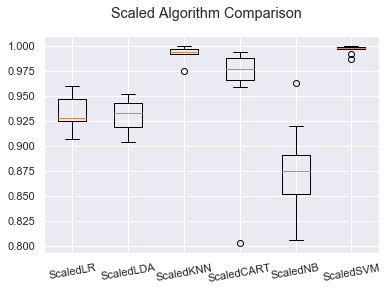

In [97]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names, rotation = '10')
plt.show()

In [98]:
# improve single model results with parameter tuning

In [99]:
# Tune scaled KNN

from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11]
param_grid = dict(n_neighbors=neighbors)
model = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.993563 using {'n_neighbors': 5}


In [100]:
means = grid_result.cv_results_['mean_test_score'] 
stds = grid_result.cv_results_['std_test_score'] 
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.991197 (0.006029) with: {'n_neighbors': 1}
0.992745 (0.006280) with: {'n_neighbors': 3}
0.993563 (0.006797) with: {'n_neighbors': 5}
0.992954 (0.005756) with: {'n_neighbors': 7}
0.990890 (0.005186) with: {'n_neighbors': 9}
0.990041 (0.005529) with: {'n_neighbors': 11}


In [101]:
# prepare the model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(rescaledX, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [102]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [103]:
# generate confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))

print()

AUC
0.8998831775700935

Accuracy
0.9273504273504274

Confusion Matrix
[[205   9]
 [  8  12]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       214
         1.0       0.57      0.60      0.59        20

    accuracy                           0.93       234
   macro avg       0.77      0.78      0.77       234
weighted avg       0.93      0.93      0.93       234




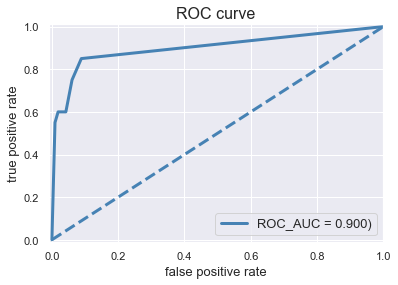

In [104]:
# generate AUC

fpr, tpr, threshold = roc_curve(Y_validation, predictions_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, color = 'steelblue', lw = 3, label = 'ROC_AUC = {:0.3f})'.format(roc_auc))
plt.xlabel('false positive rate', fontsize = 13)
plt.ylabel('true positive rate', fontsize = 13)
plt.title('ROC curve', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 13)
plt.plot([0, 1], [0, 1], color = 'steelblue', lw = 3, linestyle = '--')
# plt.axes().set_aspect('equal')
plt.show()

In [105]:
# Tune scaled SVM

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [3,4,5,6]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.998027 using {'C': 5, 'kernel': 'rbf'}


In [106]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.944695 (0.018570) with: {'C': 3, 'kernel': 'linear'}
0.991301 (0.010200) with: {'C': 3, 'kernel': 'poly'}
0.997765 (0.003786) with: {'C': 3, 'kernel': 'rbf'}
0.784240 (0.047821) with: {'C': 3, 'kernel': 'sigmoid'}
0.946029 (0.018101) with: {'C': 4, 'kernel': 'linear'}
0.991741 (0.010219) with: {'C': 4, 'kernel': 'poly'}
0.997917 (0.003807) with: {'C': 4, 'kernel': 'rbf'}
0.758505 (0.033167) with: {'C': 4, 'kernel': 'sigmoid'}
0.947033 (0.017692) with: {'C': 5, 'kernel': 'linear'}
0.991576 (0.010402) with: {'C': 5, 'kernel': 'poly'}
0.998027 (0.003678) with: {'C': 5, 'kernel': 'rbf'}
0.760038 (0.047344) with: {'C': 5, 'kernel': 'sigmoid'}
0.947378 (0.017744) with: {'C': 6, 'kernel': 'linear'}
0.991671 (0.010308) with: {'C': 6, 'kernel': 'poly'}
0.998013 (0.003773) with: {'C': 6, 'kernel': 'rbf'}
0.764321 (0.048646) with: {'C': 6, 'kernel': 'sigmoid'}


In [107]:
# prepare the model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(random_state=seed, probability = True, C=5, kernel='rbf')
model.fit(rescaledX, Y_train)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=7, shrinking=True,
    tol=0.001, verbose=False)

In [108]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [109]:
# generate confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))
print()

AUC
0.9200934579439252

Accuracy
0.9529914529914529

Confusion Matrix
[[212   2]
 [  9  11]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       214
         1.0       0.85      0.55      0.67        20

    accuracy                           0.95       234
   macro avg       0.90      0.77      0.82       234
weighted avg       0.95      0.95      0.95       234




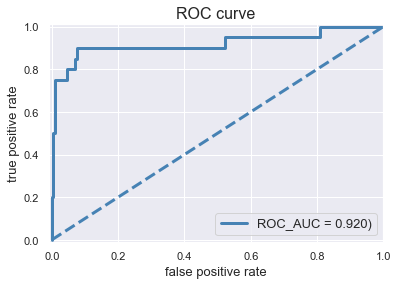

In [110]:
# generate AUC

fpr, tpr, threshold = roc_curve(Y_validation, predictions_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, color = 'steelblue', lw = 3, label = 'ROC_AUC = {:0.3f})'.format(roc_auc))
plt.xlabel('false positive rate', fontsize = 13)
plt.ylabel('true positive rate', fontsize = 13)
plt.title('ROC curve', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 13)
plt.plot([0, 1], [0, 1], color = 'steelblue', lw = 3, linestyle = '--')
# plt.axes().set_aspect('equal')
plt.show()

## 7. Fitting Ensemble Models

The goal of ensemble is to combine predictions of base estimators to improve final model performance. 

In boosting methods, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. We deliberatley choose AdaBoost and Gradient Boosting from this school of thought to fit. 

In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. We pick Random Forest and Extremley Randomized Trees to fit. 

Initial predictions, with only default hyperparameter settings, return reasonable results across the four ensembles. 

In [111]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

ensembles = []
ensembles.append(('AB', AdaBoostClassifier())) 
ensembles.append(('GBM', GradientBoostingClassifier())) 
ensembles.append(('RF', RandomForestClassifier())) 
ensembles.append(('ET', ExtraTreesClassifier())) 

results = []
names = []
for name, model in ensembles:
  kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

AB: 0.991720 (0.015759)
GBM: 0.996465 (0.009254)
RF: 0.993593 (0.011777)
ET: 0.997149 (0.005914)


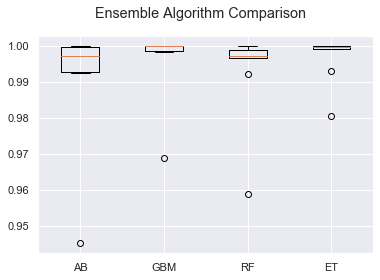

In [112]:
# Compare Algorithms

fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names)
plt.show()

In [113]:
# 6-way comparison, adding in XGBoost and LightGBM per reviewers' comments

In [114]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

ensembles = []
ensembles.append(('AB', AdaBoostClassifier())) 
ensembles.append(('GBM', GradientBoostingClassifier())) 
ensembles.append(('RF', RandomForestClassifier())) 
ensembles.append(('ET', ExtraTreesClassifier())) 
ensembles.append(('XGB', XGBClassifier())) 
ensembles.append(('LGBM', LGBMClassifier())) 

results = []
names = []
for name, model in ensembles:
  kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

AB: 0.991720 (0.015759)
GBM: 0.996452 (0.009252)
RF: 0.990161 (0.016996)
ET: 0.998357 (0.003925)
XGB: 0.997167 (0.007187)
LGBM: 0.998314 (0.003246)


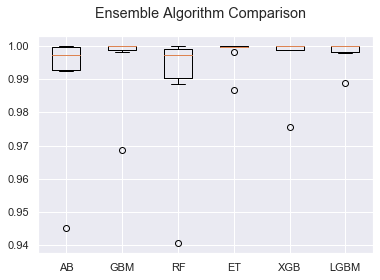

In [115]:
# Compare Algorithms

fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names)
plt.show()

## 8. Tuning Hyperparameters
- For ensmeble models there are always hyperparameters we can fine tune to yield better model performance. 

In [116]:
# Tune scaled ABM

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([300, 400, 500, 600]), learning_rate = np.array([1,0.1, 0.01]))
model = AdaBoostClassifier(random_state=seed)
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.992714 using {'learning_rate': 0.1, 'n_estimators': 600}


In [117]:
means = grid_result.cv_results_[ "mean_test_score" ]
stds = grid_result.cv_results_[ "std_test_score" ]
params = grid_result.cv_results_[ "params" ]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.991378 (0.014802) with: {'learning_rate': 1.0, 'n_estimators': 300}
0.992221 (0.015169) with: {'learning_rate': 1.0, 'n_estimators': 400}
0.991803 (0.017905) with: {'learning_rate': 1.0, 'n_estimators': 500}
0.991897 (0.017266) with: {'learning_rate': 1.0, 'n_estimators': 600}
0.992466 (0.014103) with: {'learning_rate': 0.1, 'n_estimators': 300}
0.992550 (0.014541) with: {'learning_rate': 0.1, 'n_estimators': 400}
0.992182 (0.015725) with: {'learning_rate': 0.1, 'n_estimators': 500}
0.992714 (0.014159) with: {'learning_rate': 0.1, 'n_estimators': 600}
0.973190 (0.014813) with: {'learning_rate': 0.01, 'n_estimators': 300}
0.981683 (0.014084) with: {'learning_rate': 0.01, 'n_estimators': 400}
0.984168 (0.015045) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.986146 (0.015300) with: {'learning_rate': 0.01, 'n_estimators': 600}


In [118]:
# prepare the model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = AdaBoostClassifier(random_state=seed, learning_rate = 0.1, n_estimators=600)
model.fit(rescaledX, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=600, random_state=7)

In [119]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [120]:
# generate confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))
print()

AUC
0.9836448598130841

Accuracy
0.9743589743589743

Confusion Matrix
[[214   0]
 [  6  14]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       214
         1.0       1.00      0.70      0.82        20

    accuracy                           0.97       234
   macro avg       0.99      0.85      0.90       234
weighted avg       0.98      0.97      0.97       234




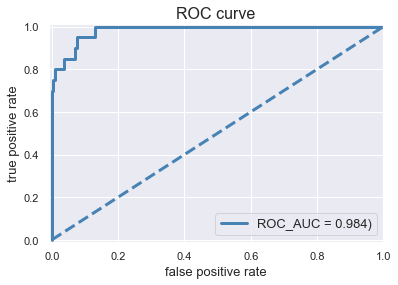

In [121]:
# generate AUC

fpr, tpr, threshold = roc_curve(Y_validation, predictions_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, color = 'steelblue', lw = 3, label = 'ROC_AUC = {:0.3f})'.format(roc_auc))
plt.xlabel('false positive rate', fontsize = 13)
plt.ylabel('true positive rate', fontsize = 13)
plt.title('ROC curve', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 13)
plt.plot([0, 1], [0, 1], color = 'steelblue', lw = 3, linestyle = '--')
# plt.axes().set_aspect('equal')
plt.show()

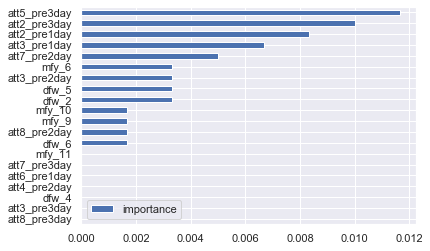

In [122]:
# generate feature importance plot 

feature_importance = pd.DataFrame(model.feature_importances_, 
                                  index = df.columns[:-1], 
                                  columns = ['importance']).sort_values('importance', ascending = True)
feature_importance[:20].plot.barh()

In [123]:
# Tune scaled GBM

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([200, 300, 400]), max_depth = np.array([10, 20, 30]))
model = GradientBoostingClassifier(random_state=seed)
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.993757 using {'max_depth': 10, 'n_estimators': 200}


In [124]:
means = grid_result.cv_results_[ "mean_test_score" ]
stds = grid_result.cv_results_[ "std_test_score" ]
params = grid_result.cv_results_[ "params" ]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.993757 (0.015823) with: {'max_depth': 10, 'n_estimators': 200}
0.993757 (0.015823) with: {'max_depth': 10, 'n_estimators': 300}
0.993757 (0.015823) with: {'max_depth': 10, 'n_estimators': 400}
0.993050 (0.015204) with: {'max_depth': 20, 'n_estimators': 200}
0.993050 (0.015204) with: {'max_depth': 20, 'n_estimators': 300}
0.993050 (0.015204) with: {'max_depth': 20, 'n_estimators': 400}
0.993050 (0.015204) with: {'max_depth': 30, 'n_estimators': 200}
0.993050 (0.015204) with: {'max_depth': 30, 'n_estimators': 300}
0.993050 (0.015204) with: {'max_depth': 30, 'n_estimators': 400}


In [125]:
# prepare the model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingClassifier(random_state=seed, max_depth = 10, n_estimators=200)
model.fit(rescaledX, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=7, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [126]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [127]:
# generate confusion matrix 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))
print()

AUC
0.9822429906542056

Accuracy
0.9572649572649573

Confusion Matrix
[[212   2]
 [  8  12]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       214
         1.0       0.86      0.60      0.71        20

    accuracy                           0.96       234
   macro avg       0.91      0.80      0.84       234
weighted avg       0.95      0.96      0.95       234




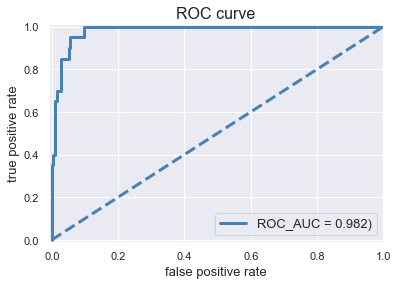

In [128]:
# generate AUC

fpr, tpr, threshold = roc_curve(Y_validation, predictions_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, color = 'steelblue', lw = 3, label = 'ROC_AUC = {:0.3f})'.format(roc_auc))
plt.xlabel('false positive rate', fontsize = 13)
plt.ylabel('true positive rate', fontsize = 13)
plt.title('ROC curve', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 13)
plt.plot([0, 1], [0, 1], color = 'steelblue', lw = 3, linestyle = '--')
# plt.axes().set_aspect('equal')
plt.show()

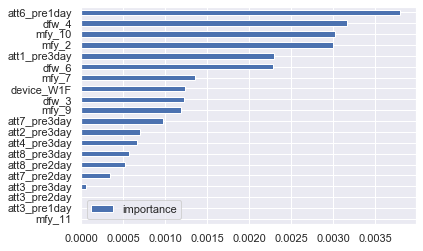

In [129]:
# generate feature importance plot

feature_importance = pd.DataFrame(model.feature_importances_, 
                                  index = df.columns[:-1], 
                                  columns = ['importance']).sort_values('importance', ascending = True)
feature_importance[:20].plot.barh()

In [130]:
# Tune scaled RF

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([400, 500, 600, 700]))
model = RandomForestClassifier(random_state=seed)
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.997042 using {'n_estimators': 700}


In [131]:
means = grid_result.cv_results_[ "mean_test_score" ]
stds = grid_result.cv_results_[ "std_test_score" ]
params = grid_result.cv_results_[ "params" ]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.996986 (0.007230) with: {'n_estimators': 400}
0.996993 (0.007299) with: {'n_estimators': 500}
0.997014 (0.007396) with: {'n_estimators': 600}
0.997042 (0.007313) with: {'n_estimators': 700}


In [132]:
# prepare the model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = RandomForestClassifier(random_state=seed, n_estimators=700)
model.fit(rescaledX, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [133]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [134]:
# generate confusion matrix 

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))
print()

AUC
0.9804906542056075

Accuracy
0.9572649572649573

Confusion Matrix
[[213   1]
 [  9  11]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       214
         1.0       0.92      0.55      0.69        20

    accuracy                           0.96       234
   macro avg       0.94      0.77      0.83       234
weighted avg       0.96      0.96      0.95       234




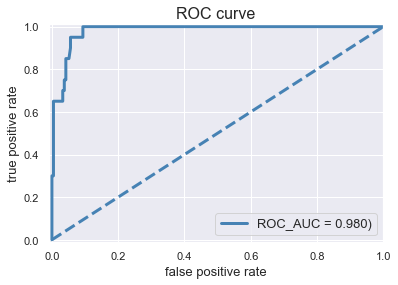

In [135]:
# generate AUC

fpr, tpr, threshold = roc_curve(Y_validation, predictions_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, color = 'steelblue', lw = 3, label = 'ROC_AUC = {:0.3f})'.format(roc_auc))
plt.xlabel('false positive rate', fontsize = 13)
plt.ylabel('true positive rate', fontsize = 13)
plt.title('ROC curve', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 13)
plt.plot([0, 1], [0, 1], color = 'steelblue', lw = 3, linestyle = '--')
# plt.axes().set_aspect('equal')
plt.show()

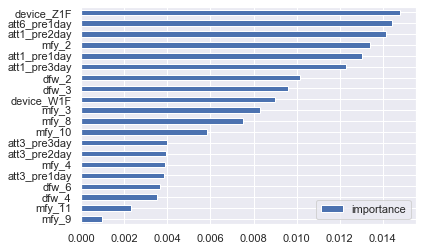

In [136]:
# generate feature importance plot

feature_importance = pd.DataFrame(model.feature_importances_, 
                                  index = df.columns[:-1], 
                                  columns = ['importance']).sort_values('importance', ascending = True)
feature_importance[:20].plot.barh()

In [137]:
# Tune scaled ET

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([400, 500, 600]), max_depth=[30,40,50])
model = ExtraTreesClassifier(random_state=seed)
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.999576 using {'max_depth': 30, 'n_estimators': 600}


In [138]:
means = grid_result.cv_results_[ "mean_test_score" ]
stds = grid_result.cv_results_[ "std_test_score" ]
params = grid_result.cv_results_[ "params" ]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.999522 (0.001255) with: {'max_depth': 30, 'n_estimators': 400}
0.999549 (0.001174) with: {'max_depth': 30, 'n_estimators': 500}
0.999576 (0.001094) with: {'max_depth': 30, 'n_estimators': 600}
0.999501 (0.001316) with: {'max_depth': 40, 'n_estimators': 400}
0.999563 (0.001134) with: {'max_depth': 40, 'n_estimators': 500}
0.999576 (0.001094) with: {'max_depth': 40, 'n_estimators': 600}
0.999508 (0.001316) with: {'max_depth': 50, 'n_estimators': 400}
0.999556 (0.001154) with: {'max_depth': 50, 'n_estimators': 500}
0.999576 (0.001094) with: {'max_depth': 50, 'n_estimators': 600}


In [139]:
# prepare the model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = ExtraTreesClassifier(random_state=seed, max_depth= 30, n_estimators=600)
model.fit(rescaledX, Y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=30, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=600,
                     n_jobs=None, oob_score=False, random_state=7, verbose=0,
                     warm_start=False)

In [140]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [141]:
# generate confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))
print()

AUC
0.9955607476635514

Accuracy
0.9786324786324786

Confusion Matrix
[[213   1]
 [  4  16]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       214
         1.0       0.94      0.80      0.86        20

    accuracy                           0.98       234
   macro avg       0.96      0.90      0.93       234
weighted avg       0.98      0.98      0.98       234




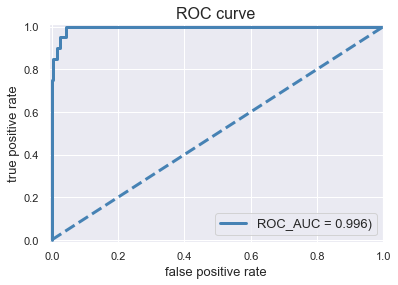

In [142]:
# generate AUC

fpr, tpr, threshold = roc_curve(Y_validation, predictions_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, color = 'steelblue', lw = 3, label = 'ROC_AUC = {:0.3f})'.format(roc_auc))
plt.xlabel('false positive rate', fontsize = 13)
plt.ylabel('true positive rate', fontsize = 13)
plt.title('ROC curve', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 13)
plt.plot([0, 1], [0, 1], color = 'steelblue', lw = 3, linestyle = '--')
# plt.axes().set_aspect('equal')
plt.show()

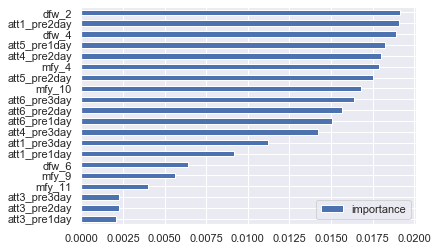

In [143]:
# generate feature importance plot

feature_importance = pd.DataFrame(model.feature_importances_, 
                                  index = df.columns[:-1], 
                                  columns = ['importance']).sort_values('importance', ascending = True)
feature_importance[:20].plot.barh()

In [144]:
# venture into XGBoost

In [145]:
# Tune scaled XGBoost

from xgboost import XGBClassifier

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([400, 500, 600]), max_depth=[5, 10, 15])
model = XGBClassifier(random_state = seed)
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.997693 using {'max_depth': 5, 'n_estimators': 600}


In [146]:
means = grid_result.cv_results_[ "mean_test_score" ]
stds = grid_result.cv_results_[ "std_test_score" ]
params = grid_result.cv_results_[ "params" ]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.997666 (0.006216) with: {'max_depth': 5, 'n_estimators': 400}
0.997666 (0.006175) with: {'max_depth': 5, 'n_estimators': 500}
0.997693 (0.006102) with: {'max_depth': 5, 'n_estimators': 600}
0.997488 (0.006339) with: {'max_depth': 10, 'n_estimators': 400}
0.997529 (0.006218) with: {'max_depth': 10, 'n_estimators': 500}
0.997502 (0.006299) with: {'max_depth': 10, 'n_estimators': 600}
0.997679 (0.005968) with: {'max_depth': 15, 'n_estimators': 400}
0.997652 (0.005968) with: {'max_depth': 15, 'n_estimators': 500}
0.997693 (0.005847) with: {'max_depth': 15, 'n_estimators': 600}


In [147]:
# prepare the model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = XGBClassifier(random_state=seed, max_depth= 5, n_estimators=600)
model.fit(rescaledX, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [148]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [149]:
# generate confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))
print()

AUC
0.9878504672897197

Accuracy
0.9658119658119658

Confusion Matrix
[[214   0]
 [  8  12]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       214
         1.0       1.00      0.60      0.75        20

    accuracy                           0.97       234
   macro avg       0.98      0.80      0.87       234
weighted avg       0.97      0.97      0.96       234




In [150]:
# venture into LightGBM

In [151]:
# Tune scaled LightGBM

from lightgbm import LGBMClassifier

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([400, 500, 600]), max_depth=[5, 10, 15])
model = LGBMClassifier(random_state = seed)
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.999180 using {'max_depth': 15, 'n_estimators': 400}


In [152]:
means = grid_result.cv_results_[ "mean_test_score" ]
stds = grid_result.cv_results_[ "std_test_score" ]
params = grid_result.cv_results_[ "params" ]
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.998744 (0.003216) with: {'max_depth': 5, 'n_estimators': 400}
0.998757 (0.003175) with: {'max_depth': 5, 'n_estimators': 500}
0.998812 (0.003016) with: {'max_depth': 5, 'n_estimators': 600}
0.999097 (0.001870) with: {'max_depth': 10, 'n_estimators': 400}
0.999111 (0.001915) with: {'max_depth': 10, 'n_estimators': 500}
0.999125 (0.001875) with: {'max_depth': 10, 'n_estimators': 600}
0.999180 (0.001598) with: {'max_depth': 15, 'n_estimators': 400}
0.999152 (0.001665) with: {'max_depth': 15, 'n_estimators': 500}
0.999166 (0.001641) with: {'max_depth': 15, 'n_estimators': 600}


In [153]:
# prepare the model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = LGBMClassifier(random_state=seed, max_depth= 15, n_estimators=400)
model.fit(rescaledX, Y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [154]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [155]:
# generate confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))
print()

AUC
0.9873831775700934

Accuracy
0.9743589743589743

Confusion Matrix
[[214   0]
 [  6  14]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       214
         1.0       1.00      0.70      0.82        20

    accuracy                           0.97       234
   macro avg       0.99      0.85      0.90       234
weighted avg       0.98      0.97      0.97       234




In [156]:
# venture into Voting Model

In [157]:
from sklearn.ensemble import VotingClassifier

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

model_AB = AdaBoostClassifier(random_state=seed, learning_rate = 0.1, n_estimators=600)
model_GBM = GradientBoostingClassifier(random_state=seed, max_depth = 10, n_estimators=200)
model_RF = RandomForestClassifier(random_state=seed, n_estimators=700)
model_ET = ExtraTreesClassifier(random_state=seed, max_depth= 10, n_estimators=600)
model_XGB = XGBClassifier(random_state=seed, max_depth= 5, n_estimators=600)
model_LGBM = LGBMClassifier(random_state=seed, max_depth= 15, n_estimators=400)

model = VotingClassifier(estimators=[('model_AB', model_AB), 
                                     ('model_GBM', model_GBM), 
                                     ('model_RF', model_RF), 
                                     ('model_ET', model_ET),
                                     ('model_XGB', model_XGB),
                                     ('model_LGBM', model_LGBM)], 
                         weights = [1, 0, 0, 1, 0, 1], 
                         voting='soft',
                         n_jobs=-1)

model.fit(rescaledX, Y_train)

VotingClassifier(estimators=[('model_AB',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=0.1,
                                                 n_estimators=600,
                                                 random_state=7)),
                             ('model_GBM',
                              GradientBoostingClassifier(criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='deviance',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                               

In [158]:
# generate prediction on validation dataset

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
predictions_proba = model.predict_proba(rescaledValidationX)

In [160]:
# generate confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print('AUC')
print(roc_auc_score(Y_validation, predictions_proba[:,1]))
print()

print('Accuracy')
print(accuracy_score(Y_validation, predictions))
print()

print('Confusion Matrix')
print(confusion_matrix(Y_validation, predictions))
print()

print('Classification Report')
print(classification_report(Y_validation, predictions))
print()

AUC
0.9934579439252337

Accuracy
0.9743589743589743

Confusion Matrix
[[214   0]
 [  6  14]]

Classification Report
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       214
         1.0       1.00      0.70      0.82        20

    accuracy                           0.97       234
   macro avg       0.99      0.85      0.90       234
weighted avg       0.98      0.97      0.97       234




## 9. Adjusting Prediction Cut-Off
- Typical cut-off for prediction is 0.5. Predicted value greater than 0.5 is consider posiitve, and below negative. 
- Currently our voting model errors on the side of false negatives. By lowering the cut-off point, we may be able to flip a few cases to positives. But we want to calibrate the cut-off point carefully so as to increase true positives as much as possible, without incurring huge increase in false positives. 


In [161]:
# pin point datapoints our model fails to correctly classify 

In [162]:
pd.Series(predictions)[pd.Series(predictions) != pd.Series(Y_validation)]

1      0.0
126    0.0
144    0.0
151    0.0
159    0.0
224    0.0
dtype: float64

In [163]:
print(predictions[1])
print(predictions_proba[1])

0.0
[0.67663781 0.32336219]


In [164]:
print(predictions[126])
print(predictions_proba[126])

0.0
[0.6897754 0.3102246]


In [165]:
print(predictions[144])
print(predictions_proba[144])

0.0
[0.64486502 0.35513498]


In [166]:
print(predictions[151])
print(predictions_proba[151])

0.0
[0.73887716 0.26112284]


In [167]:
print(predictions[159])
print(predictions_proba[159])

0.0
[0.66033935 0.33966065]


In [168]:
print(predictions[224])
print(predictions_proba[224])

0.0
[0.6922889 0.3077111]


In [169]:
custom_cut = np.where(predictions_proba > 0.31, 1, 0)
print(confusion_matrix(Y_validation, custom_cut[:,1]))

[[212   2]
 [  2  18]]


In [172]:
# persist preferred model to file

import pickle

f = open('20190516_model_et.save', 'wb')
pickle.dump(model, f, protocol = pickle.HIGHEST_PROTOCOL)
f.close()

In [173]:
# retrieve preferred model from file

# f = open('20190516_model_et.save', 'rb')
# return_tree = pickle.load(f)
# f.close()

## 10. Other Possible Explorations

Should our prediction fail to meet our expectation, there are still options we can explore. 

- Talk to domain expert, and understand the meaning of the 8 telemetry attributes. Knowing what those attributes mean, and why they are collected in the first place should give us better insight on how to construct the features to capture the device failure dynamics. 
- Collect more data, especially failure data points with diverse range across the measured attributes should enable us to train the model with more confidence, instead of relying on resampling or synthetic data points for the purpose.  
- Try other resampling methods. We have not exhausted all possible options. We might get some mileage from both undersampling of majority class, and over-sampling of minority class at the same time to yield better predictions.  
- We can experiment with more leading attribute readings, instead of just previous 1 to 3 days. 
- In model scoring, we treat the cost of making false positives and false negatives equal. If we know better the relative cost of making false positives vs. false negatives, we can factor this into optimization. The revised prediction should make more economic sense in a production setting. 


# Summary

All in all, we successfully build a model to predict device failure reasonably well. We pull in most of the data science toolsets to arrive at the milestone. We relentlessly cleanse the data. We extract and build new features. We normalize the data to be comparable across devices with different length of historical information. We fit a series of models from naive baseline, to families of classification models including KNN and SVM, to ensembles of averaging and boosting schools. We even experiment with voting model taking in best of all ensembles. We go the extra mile adjusting the prediction cut-off point to further optimize. In the end, we use 1,167 device records to train our model, and correctly classify 18 out of the 20 actual failure cases from validation pool of 234. The model precision is 90%, and recall also 90%. 